

```
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)
```



# Starter code

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=938363296b0fb575ba93afab86e1adbd2df7a15416277fb58dc082278a5fd88a
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 160.4 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# In case of OSError: [Errno 107] Transport endpoint is not connected, restart Kernel

FOLDERNAME = 'Depth_Estimation'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))




# this changes the working directory to the folder, and allows us to perform version control operations
%cd drive/My\ Drive/$FOLDERNAME
!git config --global user.email "arjun2000ashok@gmail.com"
!git config --global user.name "Arjun Ashok"



import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)

import numpy as np
np.random.seed(0)

from PIL import Image
from io import BytesIO
%matplotlib inline

%load_ext autoreload
%autoreload 2

%load_ext tensorboard

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Depth_Estimation


In [ ]:
!pip install wandb -qq
import wandb
!wandb login 

# Git commit and push

In [ ]:
# !git reset --soft HEAD~1 # UNDO PREVIOUS COMMIT AND PUT THOSE FILES IN STAGING AREA
# !git status # - VIEW STAGED, UNTRACKED FILES
# !git reset HEAD -- . # - TO UNSTAGE FILES
# !git log # LOG

In [ ]:
# !git add .
# !git commit -m 'wandb save added, tqdm removed'
# !git push -u origin master

[master 1b4553b] wandb save added, tqdm removed
 7 files changed, 16 insertions(+), 9 deletions(-)
 rewrite Depth Estimation.ipynb (93%)
Counting objects: 12, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 7.02 KiB | 479.00 KiB/s, done.
Total 12 (delta 7), reused 0 (delta 0)
remote: Resolving deltas: 100% (7/7), completed with 7 local objects.
To https://github.com/aiarjun/Monocular-Depth-Estimation.git
   f257891..1b4553b  master -> master
Branch 'master' set up to track remote branch 'master' from 'origin'.


In [2]:
# !git pull

remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.
From https://github.com/aiarjun/Monocular-Depth-Estimation
   1b4553b..c7d62e1  master     -> origin/master
Updating 1b4553b..c7d62e1
Fast-forward
 train.py | 34 +++++++++++++++++++++++-----------
 1 file changed, 23 insertions(+), 11 deletions(-)


# Testing the dataloader

In [ ]:
from utils import *

def compare_predictions(images, depths, predictions, wandb_step):
  image_plots = plot_batch_images(images)
  depth_plots = plot_batch_depths(depths)
  pred_plots = plot_batch_depths(predictions)
  difference = plot_batch_depths(torch.abs(depths - predictions))

  wandb.log({"Sample Validation images": [wandb.Image(image_plot) for image_plot in image_plots]}, step = wandb_step)
  wandb.log({"Sample Validation depths": [wandb.Image(image_plot) for image_plot in depth_plots]}, step = wandb_step)
  wandb.log({"Sample Validation predictions": [wandb.Image(image_plot) for image_plot in pred_plots]}, step = wandb_step)
  wandb.log({"Sample Validation differences": [wandb.Image(image_plot) for image_plot in difference]}, step = wandb_step)

In [ ]:
wandb.init(name="colab_test", project="first_project", reinit=True)
from matplotlib import cm

# from model.dataloader import *

# path = 'data/raw/nyu_data.zip'
# dl = DataLoaders(path)

# dl = trainer.dataloaders


a = dl.get_val_dataloader(batch_size = 8, shuffle = True)
sample = next(iter(a))
images, depths = sample['img'], sample['depth']

compare_predictions(images, depths, depths, 0)
wandb.join()
# utils.plot_sample_tensor(image, depth)

# Test code

In [ ]:
from utils import *
from model.net import DenseDepth 
from model.net import combined_loss

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model=DenseDepth() 
model = model.to(device)
load_checkpoint('experiments/train/best.pth.tar', model)
model = model.eval()
with torch.no_grad():
  predictions = model(images.cuda())
  loss = combined_loss(predictions, depths.cuda())

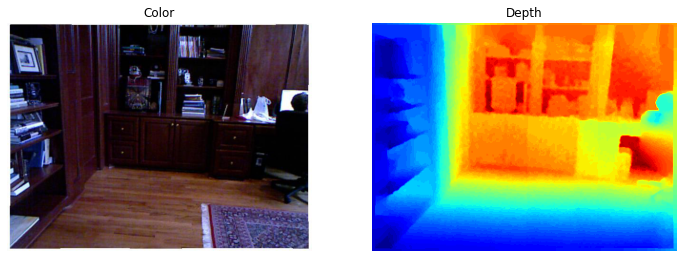

In [ ]:
plot_sample_tensor(sample['img'][0], sample['depth'][0])

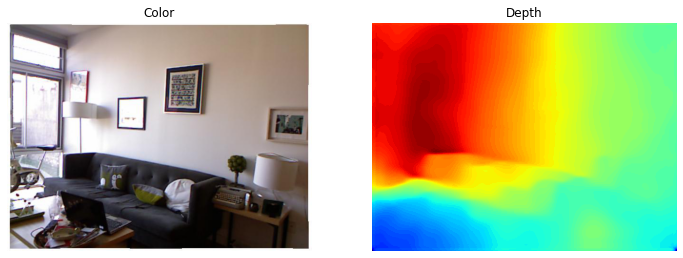

In [ ]:
plot_sample_tensor(sample['img'][2], predictions[2])

# Train

In [ ]:
# wandb.init(name="testing_model_saving", project="first_project", reinit=True)
# wandb.watch_called = False
# config = wandb.config          
# config.batch_size = 8          
# config.test_batch_size = 2
# config.epochs = 1             
# config.lr = 1e-4               
# config.cuda = True
# config.training_loss_log_interval = 10
# config.other_metrics_log_interval = 50

# from model.net import DenseDepth 
# from utils import *

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model=DenseDepth() 
# model = model.to(device)
# load_checkpoint('experiments/train/best.pth.tar', model)
# state = {'epoch':5, 'state_dict': model.state_dict()}
# save_checkpoint(state, is_best = True, checkpoint_dir = 'experiments/', train = True)

# # from train import Trainer
# # trainer = Trainer('data/raw/nyu_data.zip')

# # trainer.train_and_evaluate(batch_size = 8)
# wandb.join()

In [8]:
wandb.init(id="test", project="depth_estimation", resume='allow')
config = wandb.config          
config.batch_size = 8          
config.test_batch_size = 1
config.epochs = 15            
config.lr = 1e-4  
config.cuda = True
config.training_loss_log_interval = 5
config.other_metrics_log_interval = 10

config.done_epochs = DONE_EPOCHS
config.lr_scheduler_step_size = 3


from train import Trainer
# trainer = Trainer('data/raw/nyu_data.zip')

trainer.train_and_evaluate(config = config)

Streaming file created twice in same run: /content/drive/My Drive/Depth_Estimation/wandb/run-20200713_182233-test/wandb-history.jsonl
Streaming file created twice in same run: /content/drive/My Drive/Depth_Estimation/wandb/run-20200713_182233-test/wandb-events.jsonl


2020-07-13 23:52:44.514794+05:30 At epoch 1[0/5703]
Epoch: 1 [0 / 5703] ; it_time: 2.074905 (2.074905) ; eta: 3:17:13 ; loss: 15.941843 (15.941843)
2020-07-13 23:52:58.025296+05:30 At epoch 1[5/5703]
2020-07-13 23:53:07.639962+05:30 At epoch 1[10/5703]
Epoch: 1 [10 / 5703] ; it_time: 1.868531 (1.895535) ; eta: 2:59:51 ; loss: 15.980599 (16.601233)


KeyboardInterrupt: ignored